Loading data...
Training set shape: (4920, 133)
Test set shape: (42, 133)

Applying realistic noise to training data...
Keeping test data clean (no noise applied)...

Cleaning data...
After removing duplicates - Train: (4920, 133), Test: (42, 133)

Engineering features...

Number of classes: 41
Sample classes: ['(vertigo) Paroymsal  Positional Vertigo' 'AIDS' 'Acne'
 'Alcoholic hepatitis' 'Allergy']

Checking class distribution...
Classes with only 1 sample in train: 0
Classes with only 1 sample in test: 40
Minimum samples per class - Train: 120, Test: 1
Using stratified split for train/val...

Data splits - Train: (3936, 134), Val: (984, 134), Test: (42, 134)

Scaling features...

Training models with regularization...

VALIDATION RESULTS
Random Forest: 0.8648
SVM: 0.9248
Logistic Regression: 0.9096

Best model: SVM (Accuracy: 0.9248)

Classification Report:
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       

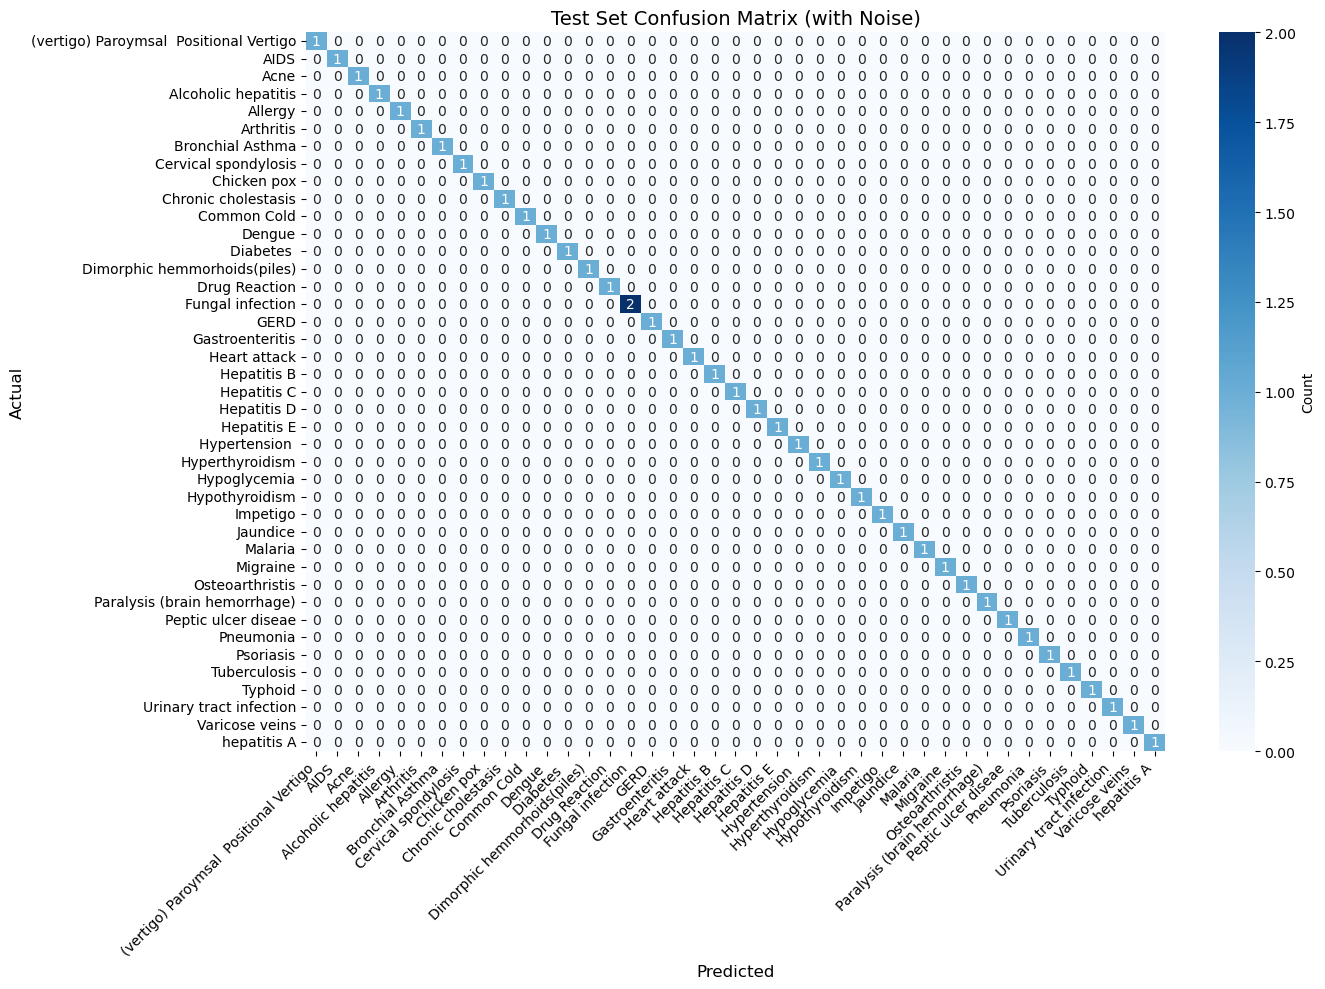


Saving models...
Models saved successfully!

EXAMPLE PREDICTION

Predicted Disease: Fungal infection

Top 5 Predictions:
  Fungal infection: 99.66%
  Drug Reaction: 0.11%
  Acne: 0.10%
  Heart attack: 0.04%
  Paralysis (brain hemorrhage): 0.02%

MODEL TRAINING COMPLETE!


In [1]:
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


#              DATA LOADING STAGE

print("Loading data...")
import os

downloads_path = os.path.join(os.path.expanduser('~'), 'Downloads')
train_path = os.path.join(downloads_path, 'Training.csv')
test_path = os.path.join(downloads_path, 'Testing.csv')

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

train = train.loc[:, ~train.columns.str.contains('^Unnamed')]
test = test.loc[:, ~test.columns.str.contains('^Unnamed')]

print(f"Training set shape: {train.shape}")
print(f"Test set shape: {test.shape}")


#           DATA RANDOMIZATION STAGE 

def add_realistic_noise(df, noise_level=0.15, flip_prob=0.05):
    """
    Add noise to make data more realistic and prevent overfitting
    
    Args:
        noise_level: Probability of adding random symptoms
        flip_prob: Probability of flipping existing symptoms
    """
    df_noisy = df.copy()
    symptom_cols = [col for col in df.columns if col != 'prognosis']
    
    np.random.seed(42)  # For reproducibility
    
    for idx in df_noisy.index:
        # Add random noise: randomly activate some inactive symptoms
        for col in symptom_cols:
            if df_noisy.loc[idx, col] == 0 and np.random.random() < noise_level:
                df_noisy.loc[idx, col] = 1
            
            # Flip existing symptoms with small probability
            if np.random.random() < flip_prob:
                df_noisy.loc[idx, col] = 1 - df_noisy.loc[idx, col]
    
    return df_noisy

print("\nApplying realistic noise to training data...")
train = add_realistic_noise(train, noise_level=0.15, flip_prob=0.05)

print("Keeping test data clean (no noise applied)...")

#               DATA CLEANING STAGE

print("\nCleaning data...")
train = train.drop_duplicates()
test = test.drop_duplicates()
print(f"After removing duplicates - Train: {train.shape}, Test: {test.shape}")


#           FEATURE ENGINEERING STAGE

def add_features(df):
    symptom_cols = [col for col in df.columns if col != 'prognosis']
    df['symptom_sum'] = df[symptom_cols].sum(axis=1)
    respiratory_cols = ['cough', 'high_fever', 'runny_nose', 'sinus_pressure', 'congestion']
    group_cols = [col for col in respiratory_cols if col in df.columns]
    if group_cols:
        df['respiratory_sum'] = df[group_cols].sum(axis=1)
    return df

print("\nEngineering features...")
train = add_features(train)
test = add_features(test)


#              TRAIN-TEST PREPARATION

X_train_full = train.drop(columns=['prognosis'])
y_train_raw = train['prognosis']

X_test_full = test.drop(columns=['prognosis'])
y_test_raw = test['prognosis']

le = LabelEncoder()
y_train_full = le.fit_transform(y_train_raw)
y_test_full = le.transform(y_test_raw)

print(f"\nNumber of classes: {len(le.classes_)}")
print(f"Sample classes: {le.classes_[:5]}")


#             CLASS DISTRIBUTION CHECK

from collections import Counter

train_counts = Counter(y_train_full)
test_counts = Counter(y_test_full)

print("\nChecking class distribution...")
print(f"Classes with only 1 sample in train: {sum(1 for count in train_counts.values() if count == 1)}")
print(f"Classes with only 1 sample in test: {sum(1 for count in test_counts.values() if count == 1)}")


#              TRAIN-VALIDATION SPLIT

min_train_samples = min(train_counts.values())
min_test_samples = min(test_counts.values())

print(f"Minimum samples per class - Train: {min_train_samples}, Test: {min_test_samples}")

if min_train_samples >= 2:
    print("Using stratified split for train/val...")
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
    )
else:
    print("Warning: Some classes have only 1 sample in train. Using random split...")
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.2, random_state=42
    )

X_test_split = X_test_full
y_test_split = y_test_full

print(f"\nData splits - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test_split.shape}")


#                FEATURE SCALING STAGE

print("\nScaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_split)
X_test_full_scaled = scaler.transform(X_test_full)


#               MODEL TRAINING STAGE (REGULARIZED)


print("\nTraining models with regularization...")

rf_model = RandomForestClassifier(
    n_estimators=50,      # Reduced from 100
    max_depth=15,         # Limit tree depth
    min_samples_leaf=2,   # Require at least 2 samples per leaf
    min_samples_split=5,  # Require 5 samples to split
    random_state=42, 
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

svc_model = SVC(
    kernel='rbf', 
    C=1.0,               # Regularization parameter
    gamma='scale',       # Kernel coefficient
    random_state=42, 
    probability=True
)
svc_model.fit(X_train_scaled, y_train)

logreg_model = LogisticRegression(
    max_iter=500, 
    C=0.1,               # Strong regularization
    penalty='l2',        # L2 regularization
    random_state=42
)
logreg_model.fit(X_train_scaled, y_train)


#             MODEL VALIDATION STAGE

print("\n" + "=" * 50)
print("VALIDATION RESULTS")
print("=" * 50)

y_val_pred_rf = rf_model.predict(X_val)
y_val_pred_svc = svc_model.predict(X_val_scaled)
y_val_pred_logreg = logreg_model.predict(X_val_scaled)

acc_rf = accuracy_score(y_val, y_val_pred_rf)
acc_svc = accuracy_score(y_val, y_val_pred_svc)
acc_logreg = accuracy_score(y_val, y_val_pred_logreg)

print(f"Random Forest: {acc_rf:.4f}")
print(f"SVM: {acc_svc:.4f}")
print(f"Logistic Regression: {acc_logreg:.4f}")

best_acc = max(acc_rf, acc_svc, acc_logreg)
if best_acc == acc_rf:
    best_model = rf_model
    best_name = "Random Forest"
    use_scaled = False
elif best_acc == acc_svc:
    best_model = svc_model
    best_name = "SVM"
    use_scaled = True
else:
    best_model = logreg_model
    best_name = "Logistic Regression"
    use_scaled = True

print(f"\nBest model: {best_name} (Accuracy: {best_acc:.4f})")

# ==================================================
#             TEST EVALUATION STAGE
# ==================================================
# Test the selected model on entirely unseen test data.
# Print accuracy and a classification report (precision, recall, F1) for all diseases.
# This is the ultimate check for real-world performance before deployment.


if use_scaled:
    y_test_pred = best_model.predict(X_test_scaled)
else:
    y_test_pred = best_model.predict(X_test_split)

test_acc = accuracy_score(y_test_split, y_test_pred)
print("\nClassification Report:")
print(classification_report(y_test_split, y_test_pred, target_names=le.classes_, zero_division=0))

# ==================================================
#             DATA VISUALIZATION STAGE
# ==================================================
cm = confusion_matrix(y_test_split, y_test_pred)
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_, cbar_kws={'label': 'Count'})
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Test Set Confusion Matrix (with Noise)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ==================================================
#          FEATURE IMPORTANCE VISUALIZATION
# ==================================================
if best_name == "Random Forest":
    importances = best_model.feature_importances_
    indices = importances.argsort()[::-1][:15]
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(indices)), importances[indices], color='steelblue')
    plt.xticks(range(len(indices)), X_train.columns[indices], rotation=45, ha='right')
    plt.xlabel("Features", fontsize=12)
    plt.ylabel("Importance", fontsize=12)
    plt.title("Top 15 Feature Importances", fontsize=14)
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

# ==================================================
#                MODEL SAVING STAGE
# ==================================================
print("\nSaving models...")
joblib.dump(best_model, 'disease_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le, 'label_encoder.pkl')
joblib.dump(X_train_full.columns.tolist(), 'symptom_columns.pkl')
joblib.dump(use_scaled, 'use_scaled.pkl')
print("Models saved successfully!")

# ==================================================
#             PREDICTION FUNCTION STAGE
# ==================================================
def predict_disease(symptom_dict):
    model = joblib.load('disease_model.pkl')
    scaler = joblib.load('scaler.pkl')
    le = joblib.load('label_encoder.pkl')
    symptom_cols = joblib.load('symptom_columns.pkl')
    use_scaled = joblib.load('use_scaled.pkl')
    
    input_arr = []
    for col in symptom_cols:
        if col in ['symptom_sum', 'respiratory_sum']:
            continue
        input_arr.append(symptom_dict.get(col, 0))
    
    input_df = pd.DataFrame([input_arr], columns=[c for c in symptom_cols if c not in ['symptom_sum', 'respiratory_sum']])
    input_df = add_features(input_df)
    
    if use_scaled:
        input_scaled = scaler.transform(input_df)
        prediction = model.predict(input_scaled)[0]
        probs = model.predict_proba(input_scaled)[0]
    else:
        prediction = model.predict(input_df)[0]
        probs = model.predict_proba(input_df)[0]
    
    predicted_disease = le.inverse_transform([prediction])[0]
    top_indices = probs.argsort()[::-1][:5]
    top_diseases = [(le.classes_[i], probs[i]) for i in top_indices]
    
    return predicted_disease, top_diseases

# ==================================================
#             EXAMPLE PREDICTION STAGE
# ==================================================
print("\n" + "=" * 50)
print("EXAMPLE PREDICTION")
print("=" * 50)

example_symptoms = {
    'itching': 1,
    'skin_rash': 1,
    'nodal_skin_eruptions': 1
}

predicted, top_5 = predict_disease(example_symptoms)
print(f"\nPredicted Disease: {predicted}")
print("\nTop 5 Predictions:")
for disease, prob in top_5:
    print(f"  {disease}: {prob*100:.2f}%")

print("\n" + "=" * 50)
print("MODEL TRAINING COMPLETE!")
print("=" * 50)

In [2]:
pip install gradio

Note: you may need to restart the kernel to use updated packages.


In [2]:
import gradio as gr
import joblib
import pandas as pd
import numpy as np

# ==================== LOAD MODELS ====================
try:
    model = joblib.load('disease_model.pkl')
    scaler = joblib.load('scaler.pkl')
    le = joblib.load('label_encoder.pkl')
    symptom_cols = joblib.load('symptom_columns.pkl')
    print("Models loaded successfully!")
except:
    print("Warning: Could not load models. Make sure you've run the training script first.")
    model = None

# ==================== FEATURE ENGINEERING ====================
def add_features(df):
    symptom_cols_only = [col for col in df.columns if col not in ['symptom_sum', 'respiratory_sum']]
    df['symptom_sum'] = df[symptom_cols_only].sum(axis=1)
    respiratory_cols = ['cough', 'high_fever', 'runny_nose', 'sinus_pressure', 'congestion']
    group_cols = [col for col in respiratory_cols if col in df.columns]
    if group_cols:
        df['respiratory_sum'] = df[group_cols].sum(axis=1)
    else:
        df['respiratory_sum'] = 0
    return df

# ==================== PREDICTION FUNCTION ====================
def predict_disease(*symptom_values):
    if model is None:
        return "Error: Models not loaded. Please run the training script first.", ""
    base_cols = [c for c in symptom_cols if c not in ['symptom_sum', 'respiratory_sum']]
    symptom_dict = {}
    for i, col in enumerate(base_cols):
        symptom_dict[col] = 1 if symptom_values[i] else 0
    if sum(symptom_dict.values()) == 0:
        return "⚠️ Please select at least one symptom", ""
    input_df = pd.DataFrame([list(symptom_dict.values())], columns=base_cols)
    input_df = add_features(input_df)
    model_name = type(model).__name__
    use_scaled = model_name in ['SVC', 'LogisticRegression']
    try:
        if use_scaled:
            input_scaled = scaler.transform(input_df)
            prediction = model.predict(input_scaled)[0]
            probs = model.predict_proba(input_scaled)[0]
        else:
            prediction = model.predict(input_df)[0]
            probs = model.predict_proba(input_df)[0]
        predicted_disease = le.inverse_transform([prediction])[0]
        top_indices = probs.argsort()[::-1][:5]
        main_result = f"### 🏥 Predicted Disease: **{predicted_disease}**\n"
        main_result += f"**Confidence:** {probs[prediction]*100:.2f}%\n\n"
        main_result += f"**Selected Symptoms:** {sum(symptom_dict.values())} symptoms"
        top_5_result = "### 📊 Top 5 Predictions:\n\n"
        for i, idx in enumerate(top_indices, 1):
            disease = le.classes_[idx]
            prob = probs[idx] * 100
            bar = "█" * int(prob / 2)
            top_5_result += f"{i}. **{disease}**\n   {bar} {prob:.2f}%\n\n"
        return main_result, top_5_result
    except Exception as e:
        return f"Error making prediction: {str(e)}", ""

# ==================== ALL SYMPTOMS ====================
all_symptoms = [
    'itching', 'skin_rash', 'nodal_skin_eruptions', 'continuous_sneezing',
    'shivering', 'chills', 'joint_pain', 'stomach_pain', 'acidity',
    'ulcers_on_tongue', 'muscle_wasting', 'vomiting', 'burning_micturition',
    'spotting_urination', 'fatigue', 'weight_gain', 'anxiety',
    'cold_hands_and_feets', 'mood_swings', 'weight_loss', 'restlessness',
    'lethargy', 'patches_in_throat', 'irregular_sugar_level', 'cough',
    'high_fever', 'sunken_eyes', 'breathlessness', 'sweating',
    'dehydration', 'indigestion', 'headache', 'yellowish_skin',
    'dark_urine', 'nausea', 'loss_of_appetite', 'pain_behind_the_eyes',
    'back_pain', 'constipation', 'abdominal_pain', 'diarrhoea',
    'mild_fever', 'yellow_urine', 'yellowing_of_eyes', 'acute_liver_failure',
    'fluid_overload', 'swelling_of_stomach', 'swelled_lymph_nodes',
    'malaise', 'blurred_and_distorted_vision', 'phlegm', 'throat_irritation',
    'redness_of_eyes', 'sinus_pressure', 'runny_nose', 'congestion',
    'chest_pain', 'weakness_in_limbs', 'fast_heart_rate',
    'pain_during_bowel_movements', 'pain_in_anal_region', 'bloody_stool',
    'irritation_in_anus', 'neck_pain', 'dizziness', 'cramps',
    'bruising', 'obesity', 'swollen_legs', 'swollen_blood_vessels',
    'puffy_face_and_eyes', 'enlarged_thyroid', 'brittle_nails',
    'swollen_extremeties', 'excessive_hunger', 'extra_marital_contacts',
    'drying_and_tingling_lips', 'slurred_speech', 'knee_pain',
    'hip_joint_pain', 'muscle_weakness', 'stiff_neck', 'swelling_joints',
    'movement_stiffness', 'spinning_movements', 'loss_of_balance',
    'unsteadiness', 'weakness_of_one_body_side', 'loss_of_smell',
    'bladder_discomfort', 'foul_smell_of_urine', 'continuous_feel_of_urine',
    'passage_of_gases', 'internal_itching', 'toxic_look_(typhos)',
    'depression', 'irritability', 'muscle_pain', 'altered_sensorium',
    'red_spots_over_body', 'belly_pain', 'abnormal_menstruation',
    'dischromic_patches', 'watering_from_eyes', 'increased_appetite',
    'polyuria', 'family_history', 'mucoid_sputum', 'rusty_sputum',
    'lack_of_concentration', 'visual_disturbances', 'receiving_blood_transfusion',
    'receiving_unsterile_injections', 'coma', 'stomach_bleeding',
    'distention_of_abdomen', 'history_of_alcohol_consumption',
    'blood_in_sputum', 'prominent_veins_on_calf',
    'palpitations', 'painful_walking', 'pus_filled_pimples',
    'blackheads', 'scurring', 'skin_peeling', 'silver_like_dusting',
    'small_dents_in_nails', 'inflammatory_nails', 'blister',
    'red_sore_around_nose', 'yellow_crust_ooze'
]

if symptom_cols:
    base_symptoms = [s for s in symptom_cols if s not in ['symptom_sum', 'respiratory_sum']]
else:
    base_symptoms = all_symptoms

# ==================== CREATE GRADIO INTERFACE ====================
with gr.Blocks(title="Disease Prediction System", theme=gr.themes.Soft()) as demo:
    gr.Markdown("# 🏥 Disease Prediction System\n### Select your symptoms below to get a disease prediction")
    with gr.Row():
        with gr.Column(scale=2):
            gr.Markdown("### 📋 Select Your Symptoms")
            symptom_checkboxes = []
            chunk_size = 20
            for i in range(0, len(base_symptoms), chunk_size):
                chunk = base_symptoms[i:i+chunk_size]
                with gr.Accordion(f"Symptoms {i+1}-{min(i+chunk_size, len(base_symptoms))}", open=(i==0)):
                    for symptom in chunk:
                        checkbox = gr.Checkbox(label=symptom.replace('_', ' ').title(), value=False)
                        symptom_checkboxes.append(checkbox)
            with gr.Row():
                predict_btn = gr.Button("🔍 Predict Disease", variant="primary", size="lg")
                clear_btn = gr.ClearButton(components=symptom_checkboxes, value="🔄 Clear All")
        with gr.Column(scale=1):
            gr.Markdown("### 📈 Prediction Results")
            prediction_output = gr.Markdown(value="Select symptoms and click **Predict Disease** to see results.", label="Main Prediction")
            top_5_output = gr.Markdown(value="", label="Top 5 Predictions")
    gr.Markdown("---\n⚠️ **Disclaimer:** This is a machine learning model for educational purposes only. Always consult with a qualified healthcare professional for medical advice.")

    predict_btn.click(
        fn=predict_disease,
        inputs=symptom_checkboxes,
        outputs=[prediction_output, top_5_output]
    )

# ==================== LAUNCH ====================
if __name__ == "__main__":
    print("\n" + "="*60)
    print("🚀 Starting Disease Prediction System UI")
    print("="*60 + "\n")
    # Pick an available port!
    demo.launch(share=False, server_name="0.0.0.0", server_port=7861)


Models loaded successfully!

🚀 Starting Disease Prediction System UI

* Running on local URL:  http://0.0.0.0:7861
* To create a public link, set `share=True` in `launch()`.
